## Rozwiązanie do pracy domowej z zajęć 22.03.2020
#### Kuba Kozłowski

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score
from sklearn.feature_selection import RFE

# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

from utils import *

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload
%aimport utils
%autoreload 1

# Case study 

Dane: HappyCustomerBank


### Opis problemu i danych:

About Company

Happy Customer Bank is a mid-sized private bank which deals in all kinds of loans. They have presence across all major cities in India and focus on lending products. They have a digital arm which sources customers from the internet.


Problem

Digital arms of banks today face challenges with lead conversion, they source leads through mediums like search, display, email campaigns and via affiliate partners. Here Happy Customer Bank faces same challenge of low conversion ratio. They have given a problem to identify the customers segments having higher conversion ratio for a specific loan product so that they can specifically target these customers, here they have provided a partial data set for salaried customers only from the last 3 months. They also capture basic details about customers like gender, DOB, existing EMI, employer Name, Loan Amount Required, Monthly Income, City, Interaction data and many others. Let’s look at the process at Happy Customer Bank.

In above process, customer applications can drop majorly at two stages, at login and approval/ rejection by bank. Here we need to identify the segment of customers having higher disbursal rate in next 30 days.

Data Set

We have train and test data set, train data set has both input and output variable(s). Need to predict probability of disbursal for test data set.


Input variables:

- ID - Unique ID (can not be used for predictions)
- Gender- Sex
- City - Current City
- Monthly_Income - Monthly Income in rupees
- DOB - Date of Birth
- Lead_Creation_Date - Lead Created on date
- Loan_Amount_Applied - Loan Amount Requested (INR)
- Loan_Tenure_Applied - Loan Tenure Requested (in years)
- Existing_EMI - EMI of Existing Loans (INR)
- Employer_Name - Employer Name
- Salary_Account- Salary account with Bank
- Mobile_Verified - Mobile Verified (Y/N)
- Var5- Continuous classified variable
- Var1- Categorical variable with multiple levels
- Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
- Loan_Tenure_Submitted- Loan Tenure Revised and Selected after seeing Eligibility (Years)
- Interest_Rate- Interest Rate of Submitted Loan Amount
- Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
- EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)
- Filled_Form- Filled Application form post quote
- Device_Type- Device from which application was made (Browser/ Mobile)
- Var2- Categorical Variable with multiple Levels
- Source- Categorical Variable with multiple Levels
- Var4- Categorical Variable with multiple Levels

Outcomes:

- LoggedIn- Application Logged (Variable for understanding the problem – cannot be used in prediction)
- Disbursed- Loan Disbursed (Target Variable)

Źródło:

https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

### Interesują nas dwie miary jakości rozwiązania: 
- AUC
- Zysk, liczony w następujący sposób:

  - zaklasyfikowanie obserwacji jako 1 kosztuje nas 100 zł (tzn. nasz model przypisuje obserwacji klasę 1),
  - trafienie predykcją w klasę 1 przynosi nam 1000 zł zarobku.

Cel: osiągnąć jak największy zysk.

#### 1. Case study - dalsza część zadania
    1.1. Przygotuj dane do klasyfikacji: 
        1.1.1. Wykonaj eksploarcyjną analizę danych
        1.1.2. Stwórz nowe zmienne, które mogą okazać się przydatne lub zmodyfikuj istniejące (np. DOB -> YOB)
        1.1.3. Uzupełnij braki w danych
        1.1.4. Wybierz zmienne kategoryczne i wykonaj encoding (metoda pd.get_dummies *pamiętaj o drop_first=True)
    1.2. Podzial dane na zbiór treningowy i testowy:
        1.2.1. Wydziel testową część zbioru, którą dołączyliśmy i odłóż na bok (brakuje tam zmiennej Disbursed więc nie możemy określić dokładności predykcji)
        1.2.2. Z pozostałego zbioru wydziel zbiór treningowy (do robienia CV) i testowy (do ostatecznych testów modeli)
    1.3. Przetestuj kilka metod radzenia sobie z niezbalansowanymi klasami w celu uzyskania największego zysku i/lub F1:
        1.3.1. Modyfikacja progu odcięcia dla prewdopodobieństawa predykcji klasy 1
        1.3.2. Wproawdzenie wag klas dla modeli, które to umożliwiają, tj.:
            - LogisticRegression
            - DecisionTreeClassifier
            - RandomForestClassifier
        1.3.3. Podstawowy lub zmodyfikowany undersampling dla walidacji krzyżowej (implementacja z zadania 2)
        1.3.4. Oversampling naiwny zgodnie z naszą implementacją
    1.4. Dla każdej z metod w 1.3. wykonaj dobór hiperparametrów, np. GridSearchCV lub RandomizedSearchCV
    1.5. Sporządź raport z uzyskiwanych maksymalnych zysków i F1 dla najlepszych modeli w ramach metod do obsługi niezbalansowanych klas i wybierz najlepszy :) 

In [3]:
def financial_score(y_true, y_pred):
    
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    
    prediction_cost = y_pred.sum() * 100
    prediction_gain = (y_true & y_pred).sum() * 1000
    
    return prediction_gain - prediction_cost

---
# 1. EDA

In [4]:
data_train = pd.read_csv('Dane/HappyCustomerBank/Train_nyOWmfK.csv', encoding='Windows-1250',
                         parse_dates=['DOB', 'Lead_Creation_Date'])
data_test = pd.read_csv('Dane/HappyCustomerBank/Test_bCtAN1w.csv', encoding='Windows-1250',
                         parse_dates=['DOB', 'Lead_Creation_Date'])

In [5]:
data_train.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,1978-05-23,2015-05-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,1985-10-07,2015-05-04,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,1981-10-10,2015-05-19,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,1987-11-30,2015-05-09,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,1984-02-17,2015-05-20,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [6]:
df = pd.concat([data_train, data_test])
df.reset_index(drop=True, inplace=True)

In [7]:
# profile = ProfileReport(df)
# profile.to_file(outputfile="happy_customer_report.html")

---
# 2. Feature Engineering

- Age - based on **YOB**

In [8]:
df['YOB'] = df['DOB'].dt.year
df.loc[df['YOB'] > 2010, 'YOB'] = df['YOB'] - 100
# data comes from 2015, so customer's Age in 2015 is calculated
df['Age'] = 2015 - df['YOB']

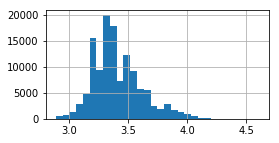

In [9]:
plt.figure(figsize=(4, 2))
np.log(df['Age']).hist(bins=30)

In [10]:
df['log_Age'] = np.log(df['Age'])

- **City**

In [11]:
top10_city_names = df.City.value_counts().index[:10]
def city_convert(x):
    if x in top10_city_names:
        return x
    else:
        return "Other"
    
df['City_converted'] = df['City'].apply(city_convert)
df['City_converted'].value_counts()

Other        37677
Delhi        17936
Bengaluru    15522
Mumbai       15425
Hyderabad    10410
Chennai       9895
Pune          7427
Kolkata       4282
Ahmedabad     2528
Jaipur        1892
Gurgaon       1743
Name: City_converted, dtype: int64

- **Monthly_Income**

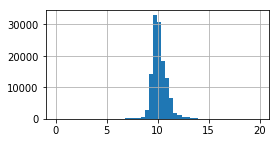

In [12]:
plt.figure(figsize=(4, 2))
np.log(df[df['Monthly_Income']>0]['Monthly_Income']).hist(bins=50)

C:\Users\jp_ko\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


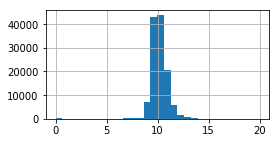

In [13]:
plt.figure(figsize=(4, 2))
df['log_Monthly_Income'] = np.log(df['Monthly_Income']).replace(-np.inf, 0)
df['log_Monthly_Income'].replace(-np.inf, 0).hist(bins=30)

- Get feature "days until end of the month" 
    - to check if bank clerks have monthly targets to do and at the end of the month give more credits
- based on **Lead_Creation_Date**

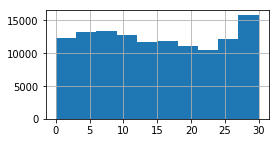

In [14]:
from pandas.tseries.offsets import MonthEnd

df['days_until_EOM'] = (df['Lead_Creation_Date'] + MonthEnd(0)) - df['Lead_Creation_Date']
df['days_until_EOM'] = df['days_until_EOM'].astype('timedelta64[D]')
plt.figure(figsize=(4, 2))
df['days_until_EOM'].hist(bins=10)

- Get feature: how many times monthly income of a person is bigger than amount applied

In [15]:
df['Loan_to_income'] = df['Monthly_Income'] / df['Loan_Amount_Applied']
df['Loan_to_income'] = df['Loan_to_income'].replace(np.inf, 0).replace(np.nan, 0)

- Get feature: if customer already has a credit or not (based on **Existing_EMI**

In [16]:
df['already_have_credit'] = (df['Existing_EMI'] > 0).astype(int)
df['already_have_credit'].value_counts(dropna=False)

0    83563
1    41174
Name: already_have_credit, dtype: int64

- **Salary Account** banks - transform

In [17]:
df['Salary_Account'].value_counts(dropna=False)[:10].sum() / df.shape[0]

0.8277736357295751

In [18]:
top10_accounts_names = df['Salary_Account'].value_counts().index[:10]
def account_convert(x):
    if x in top10_accounts_names:
        return x
    else:
        return "Other"
    
df['Salary_Account_converted'] = df['Salary_Account'].apply(account_convert)
df['Salary_Account_converted'].value_counts()

Other                   36609
HDFC Bank               25180
ICICI Bank              19547
State Bank of India     17110
Axis Bank               12590
Citibank                 3398
Kotak Bank               2955
IDBI Bank                2213
Punjab National Bank     1747
Bank of India            1713
Bank of Baroda           1675
Name: Salary_Account_converted, dtype: int64

- Get feature: **EMI_Loan_Submitted_missing**

In [19]:
df['missing_EMI_Loan_Submitted'] = df['EMI_Loan_Submitted'].isna().astype(int)

In [20]:
df[df['EMI_Loan_Submitted'].isna()==False]['Disbursed'].sum()

591.0

- Impute missing data for **Loan_Amount_Applied**

In [21]:
missing_data_mask = (df['Loan_Amount_Applied'] == 0) | (df['Loan_Amount_Applied'].isna())

df['Loan_Amount_Applied'] = impute_missing_values(df, 'Loan_Amount_Applied', missing_data_mask)

In [22]:
df['Loan_Amount_Applied'].value_counts()

100000.0     30789
200000.0     28265
300000.0     21364
500000.0     20811
1000000.0     8944
             ...  
43000.0          1
605000.0         1
157000.0         1
118000.0         1
94583.0          1
Name: Loan_Amount_Applied, Length: 319, dtype: int64

- Impute missing data for **Loan_Tenure_Applied**

In [23]:
missing_data_mask = (df['Loan_Tenure_Applied'] == 0) | (df['Loan_Tenure_Applied'].isna())

df['Loan_Tenure_Applied'] = impute_missing_values(df, 'Loan_Tenure_Applied', missing_data_mask)

In [24]:
df['Loan_Tenure_Applied'].value_counts()

5.0     44874
3.0     30738
2.0     22151
4.0     15647
1.0     11211
10.0       99
7.0         9
6.0         5
8.0         2
9.0         1
Name: Loan_Tenure_Applied, dtype: int64

- Impute missing data for **Loan_Tenure_Submitted**

In [25]:
missing_data_mask = (df['Loan_Tenure_Submitted'] == 0) | (df['Loan_Tenure_Submitted'].isna())

df['Loan_Tenure_Submitted'] = impute_missing_values(df, 'Loan_Tenure_Submitted', missing_data_mask)

In [26]:
df['Loan_Tenure_Submitted'].value_counts()

5.0    49327
4.0    36242
3.0    21094
2.0    12608
1.0     5460
6.0        6
Name: Loan_Tenure_Submitted, dtype: int64

- Impute missing data for **Loan_Amount_Submitted**

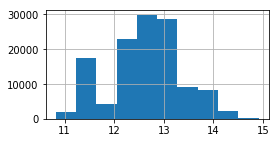

In [27]:
missing_data_mask = (df['Loan_Amount_Submitted'] == 0) | (df['Loan_Amount_Submitted'].isna())

df['Loan_Amount_Submitted'] = impute_missing_values(df, 'Loan_Amount_Submitted', missing_data_mask)
df['log_Loan_Amount_Submitted'] = np.log(df['Loan_Amount_Submitted'])

plt.figure(figsize=(4, 2))
df['log_Loan_Amount_Submitted'].hist()

- Impute missing data for **Loan_Amount_Applied**

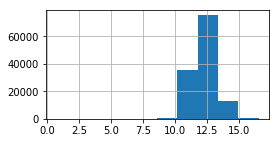

In [28]:
missing_data_mask = (df['Loan_Amount_Applied'] == 0) | (df['Loan_Amount_Applied'].isna())

df['Loan_Amount_Applied'] = impute_missing_values(df, 'Loan_Amount_Applied', missing_data_mask)
df['log_Loan_Amount_Applied'] = np.log(df['Loan_Amount_Applied'])

plt.figure(figsize=(4, 2))
df['log_Loan_Amount_Applied'].hist()

- **Mobile_Verified** get binary

In [29]:
df['Mobile_Verified'] = np.where(df['Mobile_Verified'] == 'Y', 1, 0)

- **Filled_Form** get binary

In [30]:
df['Filled_Form'] = np.where(df['Filled_Form'] == 'Y', 1, 0)

- **Source**

In [31]:
df['Source'] = recategorize_variable(df, 'Source', 2)
df['Source'].value_counts()

S122     55249
S133     42900
Other    26588
Name: Source, dtype: int64

- **Var1**

In [32]:
df['Var1'] = recategorize_variable(df, 'Var1', 1)
df['Var1'].value_counts()

HBXX     84901
Other    39836
Name: Var1, dtype: int64

- **Var2**

In [33]:
df['Var2'] = recategorize_variable(df, 'Var2', 2)
df['Var2'].value_counts()

B        53481
G        47338
Other    23918
Name: Var2, dtype: int64

---
## Initial Feature Selection
- drop already used and transformed variables
- drop meaningless fields (ex. ID)
- drop columns with overwhelming majority of missing values
- drop correlated variables

In [34]:
df.columns

Index(['City', 'DOB', 'Device_Type', 'Disbursed', 'EMI_Loan_Submitted',
       'Employer_Name', 'Existing_EMI', 'Filled_Form', 'Gender', 'ID',
       'Interest_Rate', 'Lead_Creation_Date', 'Loan_Amount_Applied',
       'Loan_Amount_Submitted', 'Loan_Tenure_Applied', 'Loan_Tenure_Submitted',
       'LoggedIn', 'Mobile_Verified', 'Monthly_Income', 'Processing_Fee',
       'Salary_Account', 'Source', 'Var1', 'Var2', 'Var4', 'Var5', 'YOB',
       'Age', 'log_Age', 'City_converted', 'log_Monthly_Income',
       'days_until_EOM', 'Loan_to_income', 'already_have_credit',
       'Salary_Account_converted', 'missing_EMI_Loan_Submitted',
       'log_Loan_Amount_Submitted', 'log_Loan_Amount_Applied'],
      dtype='object')

In [35]:
cols_to_drop = ['City', 'DOB', 'EMI_Loan_Submitted', 'Employer_Name',
                'Existing_EMI', 'ID', 'Interest_Rate', 'Lead_Creation_Date',
                'Monthly_Income',
                'Loan_Amount_Applied', 'Loan_Amount_Submitted',
                'LoggedIn', 'Processing_Fee', 'Salary_Account', 'YOB', 'Age']

df2 = df.drop(columns=cols_to_drop)

### Correlation

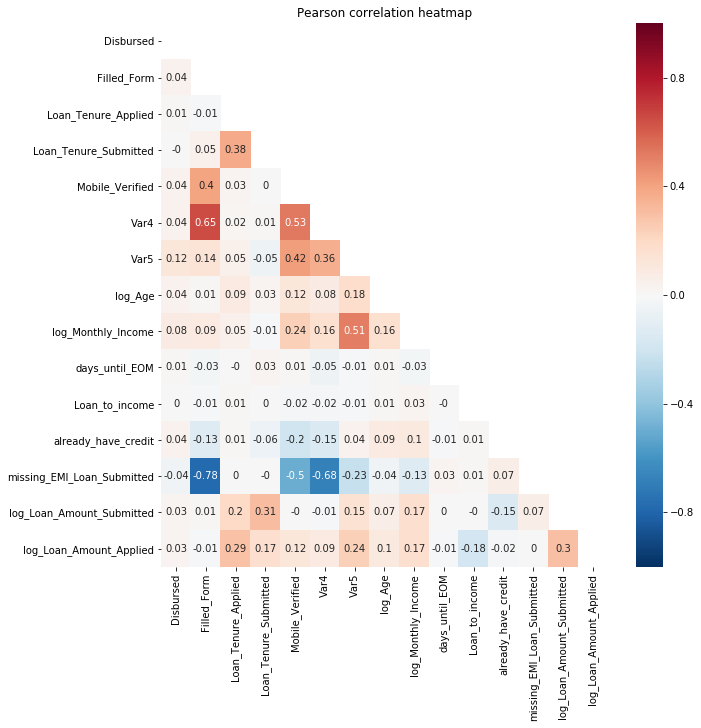

In [36]:
plot_corr_heatmap(df2, size=(10, 10))

In [37]:
# plot_corr_heatmap(df2, method='kendall', size=(10, 10))

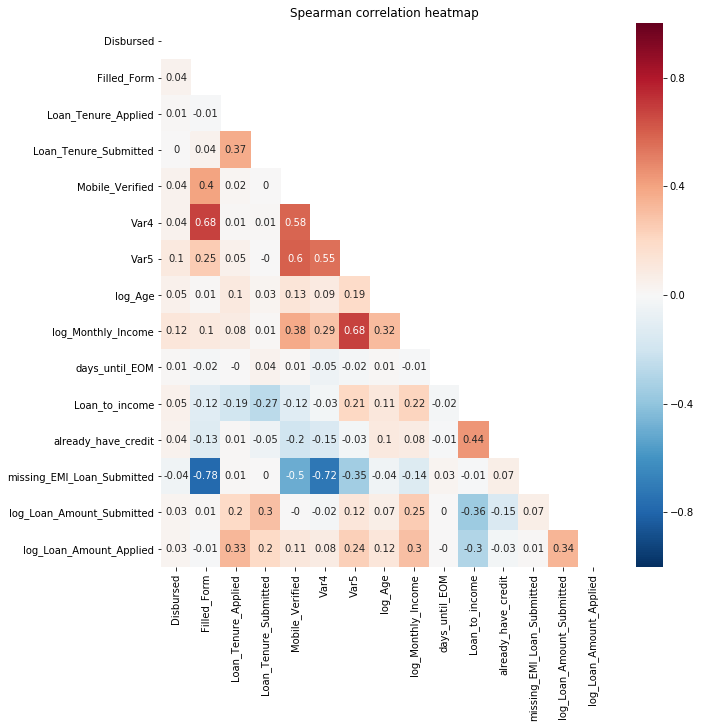

In [38]:
plot_corr_heatmap(df2, method='spearman', size=(10, 10))

**None of selected columns seems to be correlated (> 0.75 or < -0.75) hence I decide to keep all of them.**

---
## Encode variables and divide dataset into train and test sets

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124737 entries, 0 to 124736
Data columns (total 22 columns):
Device_Type                   124737 non-null object
Disbursed                     87020 non-null float64
Filled_Form                   124737 non-null int32
Gender                        124737 non-null object
Loan_Tenure_Applied           124737 non-null float64
Loan_Tenure_Submitted         124737 non-null float64
Mobile_Verified               124737 non-null int32
Source                        124737 non-null object
Var1                          124737 non-null object
Var2                          124737 non-null object
Var4                          124737 non-null int64
Var5                          124737 non-null int64
log_Age                       124737 non-null float64
City_converted                124737 non-null object
log_Monthly_Income            124737 non-null float64
days_until_EOM                124737 non-null float64
Loan_to_income                124737 non

In [40]:
categorical_variables = ['Device_Type', 'Gender',
       'Source', 'Var1', 'Var2', 'City_converted',
       'Salary_Account_converted']

df3 = pd.get_dummies(df2, columns=categorical_variables, drop_first=True)

df3.head(2)

,Disbursed,Filled_Form,Loan_Tenure_Applied,Loan_Tenure_Submitted,Mobile_Verified,Var4,Var5,log_Age,log_Monthly_Income,days_until_EOM,...,Salary_Account_converted_Bank of Baroda,Salary_Account_converted_Bank of India,Salary_Account_converted_Citibank,Salary_Account_converted_HDFC Bank,Salary_Account_converted_ICICI Bank,Salary_Account_converted_IDBI Bank,Salary_Account_converted_Kotak Bank,Salary_Account_converted_Other,Salary_Account_converted_Punjab National Bank,Salary_Account_converted_State Bank of India
0,0.0,0,5.0,4.0,0,1,0,3.610918,9.903488,16.0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0,2.0,2.0,1,3,13,3.401197,10.463103,27.0,...,0,0,0,0,1,0,0,0,0,0


### Separate train and test files, and split training set

In [41]:
df_train = df3.loc[:data_train.index.max()].copy()
df_test = df3.loc[data_train.index.max():].copy()

X = df_train.drop(columns=['Disbursed'])
y = df_train['Disbursed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1920, stratify=y)

In [42]:
y_train.sum(), y_test.sum()

(853.0, 420.0)

In [43]:
y_train.shape[0] / y_train.sum(), y_test.shape[0] / y_test.sum()

(68.35052754982415, 68.37380952380953)

----
# * Baseline model - without class reshaping

In [44]:
# DF to keep models performance
summary = pd.DataFrame()

In [45]:
tree = DecisionTreeClassifier(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
logreg = LogisticRegression(penalty='l1', class_weight='balanced', n_jobs=-1)
# svc = SVC(class_weight='balanced', probability=True)

voting_clf = VotingClassifier(
#     estimators=[('tree', tree), ('forest', forest), ('logreg', logreg), ('svc', svc)],
    estimators=[('tree', tree), ('forest', forest), ('logreg', logreg)],
    voting='soft',
    n_jobs=-1
)

models_list = [tree, forest, logreg, voting_clf]

simplefilter(action='ignore', category=UserWarning)

for model in models_list:
    model_name = type(model).__name__ + '_baseline'
    print(model_name)
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    model_metrics = assess_model(model_name,
                                 y_test.values, y_pred_proba,
                                 metric_to_optimise_treshold='financial score',
                                 class_balancing='class weight balanced')
    summary = summary.append(model_metrics)
    
summary

DecisionTreeClassifier_baseline
RandomForestClassifier_baseline
LogisticRegression_baseline
VotingClassifier_baseline


,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced


---
## Undersampling

In [46]:
forest = RandomForestClassifier()

y_pred_proba, y_true = cv_undersampling(X.values, y.values, forest, size=1, cv=StratifiedKFold(5))
print(roc_auc_score(y_true=y_true, y_score=y_pred_proba))

0.7884654522345653


In [47]:
summary = summary.append(assess_model('Forest_baseline_undes', y_true, y_pred_proba,
                         metric_to_optimise_treshold='financial score',
                         class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling


## Oversampling

In [48]:
forest = RandomForestClassifier()

p, l = cross_validate_oversampling(X, y, forest, size=1, cv=StratifiedKFold(5))
print(roc_auc_score(y_true=l, y_score=p))

0.6038903053284389


In [49]:
summary = summary.append(assess_model('Forest_baseline_overs', np.array(l), np.array(p),
                         metric_to_optimise_treshold='financial score',
                         class_balancing='cv_oversampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling
0,Forest_baseline_overs,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_oversampling


# Feature Selection
### a) RFE

In [50]:
rfe = RFE(RandomForestClassifier(), 15, step=1)
rfe.fit(X_train, y_train)
X.columns[rfe.support_]

Index(['Loan_Tenure_Applied', 'Loan_Tenure_Submitted', 'Var4', 'Var5',
       'log_Age', 'log_Monthly_Income', 'days_until_EOM', 'Loan_to_income',
       'log_Loan_Amount_Submitted', 'log_Loan_Amount_Applied', 'Source_S122',
       'Source_S133', 'City_converted_Mumbai',
       'Salary_Account_converted_HDFC Bank',
       'Salary_Account_converted_ICICI Bank'],
      dtype='object')

### b) Gradient Boosting feature importances with GridSearch
_careful, takes nearly 1 hour_

In [51]:
# n_estimators = range(50, 100, 10)
# max_depth = [3, 4, 5]
# min_samples_split = range(30, 50, 10)
# min_samples_leaf = range(20, 50, 10)

# features_gbc = []

# for n_est in n_estimators:
#     for max_d in max_depth:
#         for min_ss in min_samples_split:
#             for min_leaf in min_samples_leaf:
#                 GBC = GradientBoostingClassifier(
#                          verbose=2,
#                          n_estimators=n_est,
#                          max_depth=max_d,
#                          min_samples_leaf=min_leaf,
#                          min_samples_split=min_ss
#                 )
#                 GBC.fit(X_train, y_train)
#                 features_gbc.append(GBC.feature_importances_)

In [53]:
# features_gbc_avg = sum(features_gbc) / len(features_gbc)

### c) Random Forest with feature importances GridSearch

In [54]:
# n_estimators = [100, 150, 200]
# max_features = ['auto', 'sqrt', 'log2']
# max_depth = [4, 5, 6, 7, 8]
# criterion = ['gini', 'entropy']

# features_forest = []

# for n_est in n_estimators:
#     for max_f in max_features:
#         for max_d in max_depth:
#             for crit in criterion:
#                 RF = RandomForestClassifier(
#                          verbose=0,
#                          n_estimators=n_est,
#                          max_features=max_f,
#                          max_depth=max_d,
#                          criterion=crit,
#                          n_jobs=-1
#                 )
                
#                 RF.fit(X_train, y_train)
#                 y_pred_proba = model.predict_proba(X_test)[:,1]
    
# #                 model_name = type(model).__name__ + '_'.join([str(n_est), max_f, str(max_d), crit])
# #                 summary = summary.append(assess_model(model_name,
# #                                                       y_test.values, y_pred_proba,
# #                                                       metric_to_optimise_treshold='financial score',
# #                                                       class_balancing='class weight balanced'))
                
#                 features_forest.append(RF.feature_importances_)

In [55]:
# features_forest_avg = sum(features_forest) / len(features_forest)

In [56]:
# features_avg = (features_forest_avg + features_gbc_avg) / 2

# feature_importances_df = pd.DataFrame({'col': X_train.columns,
#                                        'importance': features_avg})
# feature_importances_df.sort_values('importance', ascending=False, inplace=True)

# ntop_feats = 15

# plt.figure(figsize=[6, 4])
# plt.title("Top features")
# plt.bar(range(ntop_feats), feature_importances_df['importance'].head(ntop_feats), color="r", align="center")
# plt.xticks(range(ntop_feats), feature_importances_df['col'].head(ntop_feats), rotation=90)
# plt.xlim([-1, ntop_feats])
# plt.show()

# features_to_keep = feature_importances_df['col'].head(ntop_feats)
# print(features_to_keep)

In [57]:
# features_to_keep.values

In [58]:
features_to_keep = ['log_Monthly_Income', 'Var5', 'Loan_to_income',
       'log_Loan_Amount_Submitted', 'log_Age', 'days_until_EOM',
       'log_Loan_Amount_Applied', 'Var4', 'already_have_credit',
       'Filled_Form', 'Salary_Account_converted_Other', 'Gender_Male',
       'Device_Type_Web-browser', 'Loan_Tenure_Applied',
       'missing_EMI_Loan_Submitted']

### GBC with undersampling

In [59]:
GBC_baseline = GradientBoostingClassifier()

y_pred_proba, y_true = cv_undersampling(X.values, y.values,
                                        GBC_baseline, size=1, cv=StratifiedKFold(5))

summary = summary.append(assess_model('GBC_baseline_unders', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                            class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling
0,Forest_baseline_overs,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_oversampling
0,GBC_baseline_unders,0.95,0.004630,0.985176,0.002357,700,0.501062,cv_undersampling


### Same models with top best features

In [60]:
X_train2 = X_train[X_train.columns[X_train.columns.isin(features_to_keep)]]
X_test2 = X_test[X_test.columns[X_test.columns.isin(features_to_keep)]]

X2 = X[X.columns[X.columns.isin(features_to_keep)]]

In [61]:
GBC = GradientBoostingClassifier()

y_pred_proba, y_true = cv_undersampling(X2.values, y.values, GBC, size=1, cv=StratifiedKFold(5))
summary = summary.append(assess_model('GBC_topfeats', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                                      class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling
0,Forest_baseline_overs,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_oversampling
0,GBC_baseline_unders,0.95,0.004630,0.985176,0.002357,700,0.501062,cv_undersampling
0,GBC_topfeats,0.96,0.003115,0.985291,0.001571,900,0.500733,cv_undersampling


In [62]:
GBC_topfeats1 = GradientBoostingClassifier(verbose=0,
                                 n_estimators=80,
                                 max_depth=3,
                                 min_samples_leaf=40,
                                 min_samples_split=40)

y_pred_proba, y_true = cv_undersampling(X2.values, y.values, GBC_topfeats1, size=1, cv=StratifiedKFold(5))
summary = summary.append(assess_model('GBC_topfeats1', y_true, y_pred_proba, metric_to_optimise_treshold='financial score',
                                      class_balancing='cv_undersampling'))
summary

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling
0,Forest_baseline_overs,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_oversampling
0,GBC_baseline_unders,0.95,0.004630,0.985176,0.002357,700,0.501062,cv_undersampling
0,GBC_topfeats,0.96,0.003115,0.985291,0.001571,900,0.500733,cv_undersampling
0,GBC_topfeats1,0.95,0.001566,0.985348,0.000786,600,0.500375,cv_undersampling


In [63]:
tree = DecisionTreeClassifier(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
logreg = LogisticRegression(penalty='l1', class_weight='balanced', n_jobs=-1)

voting_clf = VotingClassifier(
    estimators=[('tree', tree), ('forest', forest), ('logreg', logreg)],
    voting='soft',
    n_jobs=-1
)

models_list = [tree, forest, logreg, voting_clf]

simplefilter(action='ignore', category=UserWarning)

for model in models_list:
    model_name = type(model).__name__ + '_topfeats'
    print(model_name)
    
    model.fit(X_train2, y_train)
    y_pred_proba = model.predict_proba(X_test2)[:, 1]
    
    model_metrics = assess_model(model_name,
                                 y_test.values, y_pred_proba,
                                 metric_to_optimise_treshold='financial score',
                                 class_balancing='class weight balanced')
    summary = summary.append(model_metrics)
    
summary

DecisionTreeClassifier_topfeats
RandomForestClassifier_topfeats
LogisticRegression_topfeats
VotingClassifier_topfeats


,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,DecisionTreeClassifier_baseline,0.01,0.056537,0.972107,0.057143,-18900,0.521415,class weight balanced
0,RandomForestClassifier_baseline,0.38,0.034261,0.984295,0.019048,3300,0.508835,class weight balanced
0,LogisticRegression_baseline,0.92,0.050725,0.981753,0.033333,800,0.514582,class weight balanced
0,VotingClassifier_baseline,0.67,0.042553,0.984330,0.023810,5000,0.511198,class weight balanced
0,Forest_baseline_undes,0.99,0.059806,0.972179,0.060487,-53200,0.523100,cv_undersampling
0,Forest_baseline_overs,0.99,0.000000,0.985371,0.000000,0,0.500000,cv_oversampling
0,GBC_baseline_unders,0.95,0.004630,0.985176,0.002357,700,0.501062,cv_undersampling
0,GBC_topfeats,0.96,0.003115,0.985291,0.001571,900,0.500733,cv_undersampling
0,GBC_topfeats1,0.95,0.001566,0.985348,0.000786,600,0.500375,cv_undersampling
0,DecisionTreeClassifier_topfeats,0.99,0.036014,0.972037,0.035714,-26300,0.510825,class weight balanced


# GridSearch
### a) GradientBoostingClassifier without undersampling

In [64]:
n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

features_gbc = []
models = {}

for n_est in n_estimators:
    for max_d in max_depth:
        for min_ss in min_samples_split:
            for min_leaf in min_samples_leaf:
                
                GBC = GradientBoostingClassifier(
                         verbose=1,
                         n_estimators=n_est,
                         max_depth=max_d,
                         min_samples_leaf=min_leaf,
                         min_samples_split=min_ss
                )
                GBC.fit(X_train, y_train)
                
                y_pred_proba = GBC.predict_proba(X_test)[:, 1]
    
                model_name = type(GBC).__name__ + '_'.join([str(n_est), str(max_d), str(min_ss), str(min_leaf)])
        
                models[model_name] = GBC
                
                summary = summary.append(assess_model(model_name,
                                                      y_test.values, y_pred_proba,
                                                      metric_to_optimise_treshold='financial score',
                                                      class_balancing='None'))

      Iter       Train Loss   Remaining Time 
         1           0.1487            3.57s
         2           0.1456            3.42s
         3           0.1435            3.42s
         4           0.1417            3.28s
         5           0.1401            3.26s
         6           0.1388            3.14s
         7           0.1378            3.04s
         8           0.1368            2.95s
         9           0.1359            2.93s
        10           0.1351            2.84s
        20           0.1307            2.13s
        30           0.1282            1.41s
        40           0.1267            0.68s
        50           0.1254            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1487            3.57s
         2           0.1456            3.42s
         3           0.1435            3.44s
         4           0.1417            3.29s
         5           0.1401            3.25s
         6           0.1388            3.15s
        

### b) GradientBoostingClassifier with undersampling

In [65]:
n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

for n_est in n_estimators:
    for max_d in max_depth:
        for min_ss in min_samples_split:
            for min_leaf in min_samples_leaf:
                GBC = GradientBoostingClassifier(
                         verbose=0,
                         n_estimators=n_est,
                         max_depth=max_d,
                         min_samples_leaf=min_leaf,
                         min_samples_split=min_ss
                )
                
                model_name = type(GBC).__name__ + '_'.join([str(n_est), str(max_d), str(min_ss), str(min_leaf)])
#                 models[model_name] = GBC
                y_pred_proba, y_true = cv_undersampling(X.values, y.values,
                                                        GBC, size=1,
                                                        cv=StratifiedKFold(5))

                model_metrics = assess_model(model_name,
                                             y_true, y_pred_proba,
                                             metric_to_optimise_treshold='financial score',
                                             class_balancing='cv_undersampling')
        
                print(model_name, model_metrics['financial score'].values)
                summary = summary.append(model_metrics)

GradientBoostingClassifier50_3_30_20 [200]
GradientBoostingClassifier50_3_30_30 [600]
GradientBoostingClassifier50_3_30_40 [1100]
GradientBoostingClassifier50_3_40_20 [1800]
GradientBoostingClassifier50_3_40_30 [800]
GradientBoostingClassifier50_3_40_40 [9900]
GradientBoostingClassifier50_4_30_20 [0]
GradientBoostingClassifier50_4_30_30 [2400]
GradientBoostingClassifier50_4_30_40 [1600]
GradientBoostingClassifier50_4_40_20 [5200]
GradientBoostingClassifier50_4_40_30 [0]
GradientBoostingClassifier50_4_40_40 [2100]
GradientBoostingClassifier50_5_30_20 [0]
GradientBoostingClassifier50_5_30_30 [0]
GradientBoostingClassifier50_5_30_40 [800]
GradientBoostingClassifier50_5_40_20 [0]
GradientBoostingClassifier50_5_40_30 [3600]
GradientBoostingClassifier50_5_40_40 [700]
GradientBoostingClassifier60_3_30_20 [7600]
GradientBoostingClassifier60_3_30_30 [400]
GradientBoostingClassifier60_3_30_40 [0]
GradientBoostingClassifier60_3_40_20 [5500]
GradientBoostingClassifier60_3_40_30 [0]
GradientBoostin

In [66]:
summary.sort_values('financial score', ascending=False).head()

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,GradientBoostingClassifier50_5_30_20,0.10,0.137652,0.977748,0.121429,18900,0.555943,None
0,GradientBoostingClassifier50_5_40_20,0.10,0.137652,0.977748,0.121429,18900,0.555943,None
0,GradientBoostingClassifier60_3_40_40,0.08,0.139417,0.976355,0.130952,18100,0.559928,None
0,GradientBoostingClassifier60_3_30_40,0.08,0.139417,0.976355,0.130952,18100,0.559928,None
0,GradientBoostingClassifier50_4_30_30,0.08,0.142857,0.974510,0.145238,17600,0.566028,None


### c) XGBoost without undersampling

In [ ]:
# n_estimators = range(50, 100, 10)
max_depth = [3, 4, 5]
min_samples_split = range(30, 50, 10)
min_samples_leaf = range(20, 50, 10)

n_estimators = [30, 32, 35, 38, 40, 42]
learning_rate = [0.1, 0.2, 0.25, 0.28, 0.3, 0.32]

models_xgb = {}

for n_est in n_estimators:
    for lr in learning_rate:
#         for min_ss in min_samples_split:
#             for min_leaf in min_samples_leaf:
                
        XGB = XGBClassifier(
                 verbose=1,
                 n_estimators=n_est,
                 learning_rate=lr,
                 n_jobs=-1
        )
        XGB.fit(X_train, y_train)

        y_pred_proba = XGB.predict_proba(X_test)[:, 1]

        model_name = type(XGB).__name__ + '_'.join(['_', str(n_est), str(lr)])

        models_xgb[model_name] = XGB

        model_metrics = assess_model(model_name,
                                     y_test, y_pred_proba,
                                     metric_to_optimise_treshold='financial score',
                                     class_balancing='None')
        
        print(model_name, model_metrics['financial score'].values[0])
        summary = summary.append(model_metrics)

In [68]:
summary.sort_values('financial score', ascending=False).head(20)

,model,thresholds,F1,precision (PPV),recall (TPR),financial score,roc_auc_score,class_balancing
0,XGBClassifier__40_0.25,0.11,0.142235,0.979420,0.116667,22100,0.554446,None
0,XGBClassifier__42_0.25,0.11,0.142029,0.979385,0.116667,22000,0.554428,None
0,XGBClassifier__38_0.25,0.11,0.134503,0.979385,0.109524,19600,0.550910,None
0,GradientBoostingClassifier50_5_30_20,0.10,0.137652,0.977748,0.121429,18900,0.555943,None
0,GradientBoostingClassifier50_5_40_20,0.10,0.137652,0.977748,0.121429,18900,0.555943,None
0,XGBClassifier__32_0.1,0.10,0.130758,0.979629,0.104762,18700,0.548688,None
0,GradientBoostingClassifier60_3_30_40,0.08,0.139417,0.976355,0.130952,18100,0.559928,None
0,GradientBoostingClassifier60_3_40_40,0.08,0.139417,0.976355,0.130952,18100,0.559928,None
0,XGBClassifier__35_0.25,0.12,0.119403,0.981509,0.085714,17700,0.540260,None
0,GradientBoostingClassifier60_5_40_20,0.11,0.130682,0.978689,0.109524,17600,0.550557,None


In [76]:
y_pred_proba = models_xgb["XGBClassifier__40_0.25"].predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.11).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(financial_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     28297
         1.0       0.18      0.12      0.14       420

   micro avg       0.98      0.98      0.98     28717
   macro avg       0.58      0.55      0.57     28717
weighted avg       0.98      0.98      0.98     28717

[[28077   220]
 [  371    49]]
22100
0.5544459954529927


# (in)famous GridSearch on XGBoost

In [82]:
eval_set = [(X_test, y_test)]

xgb_model = XGBClassifier(eval_metric="auc", eval_set=eval_set)
target_class_weight = int((y_train.shape[0] - y_train.sum()) / y_train.sum())

parameters = {'learning_rate': [0.01],
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [9, 10, 11],
#               'silent': [1],
#               'nthread': [4], #when use hyperthread, xgboost may become slower
#               'subsample': [0.8, 0.9, 0.95],
#               'colsample_bytree': [0.6, 0.7, 0.8],
#               'scale_pos_weight': [target_class_weight],
              'n_estimators': [1000]} #number of trees, change it to 1000 for better results}

grid_xgb = GridSearchCV(xgb_model,
                   parameters,
                   n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2), 
                   scoring='roc_auc',
                   verbose=3, refit=True)

grid_xgb.fit(X_train, y_train)

y_pred_proba = grid_xgb.predict_proba(X_test)[:, 1]
tr = get_thresholds(y_test, y_pred_proba).sort_values('financial score', ascending=False)['thresholds'].values[0]
y_pred = (y_pred_proba > tr).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(financial_score(y_test, y_pred))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.6min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.6min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.7min finished


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     28297
         1.0       0.16      0.11      0.13       420

   micro avg       0.98      0.98      0.98     28717
   macro avg       0.58      0.55      0.56     28717
weighted avg       0.97      0.98      0.98     28717

[[28069   228]
 [  375    45]]
17700


In [84]:
model_metrics = assess_model(model_name,
                             y_test, y_pred_proba,
                             metric_to_optimise_treshold='financial score',
                             class_balancing='None')

print(model_name, model_metrics['financial score'].values[0])
summary = summary.append(model_metrics)

XGBClassifier__42_0.32 17700


In [98]:
def get_model_types(model_name_with_params):
    # Remove additional comments
    model_type = model_name_with_params.split('_')[0]
    
    # Remove values of parameters
    result = ''.join([char for char in model_type if not char.isdigit()])
    
    return result
    
summary['model_type'] = summary['model'].apply(get_model_types)

In [104]:
model_types_summary = summary.groupby(['model_type', 'class_balancing'], as_index=False)[['financial score', 'F1', 'roc_auc_score']].max()
model_types_summary.sort_values('financial score', ascending=False)

,model_type,class_balancing,financial score,F1,roc_auc_score
9,XGBClassifier,None,22100,0.152134,0.587441
4,GradientBoostingClassifier,None,18900,0.158996,0.601080
5,GradientBoostingClassifier,cv_undersampling,11000,0.089920,0.532969
8,VotingClassifier,class weight balanced,5000,0.042553,0.511198
7,RandomForestClassifier,class weight balanced,3300,0.034261,0.508835
3,GBC,cv_undersampling,900,0.004630,0.501062
6,LogisticRegression,class weight balanced,800,0.050725,0.514582
1,Forest,cv_oversampling,0,0.000000,0.500000
0,DecisionTreeClassifier,class weight balanced,-18900,0.056537,0.521415
2,Forest,cv_undersampling,-53200,0.059806,0.523100
